# Palisades and Eaton Fires

## About the Data





In [1]:
# Import Libraries

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr   
import rioxarray as rioxr
import contextily as ctx

In [2]:
# Import Data 

# Fire Perimeter Data
eaton = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')) # Eaton Fire Perimeter

palisades = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')) # Palisades Fire Perimeter

# Landsat NetCDF File
landsat = xr.open_dataset(os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc'))

## Landsat Data Exploration

In [3]:
# Explore landsat data (see attributes, variables, and dimensions)
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [4]:
# Check units of landsat data coordinates 
print(f'x coordinates have unit: {landsat["x"].attrs.get("units")}')
print(f'y coordinates have unit: {landsat["y"].attrs.get("units")}')

x coordinates have unit: metre
y coordinates have unit: metre


## Landsat Data Exploration Summary WRITE DESCRIPTION HERE 
The `coordinates` have an `x` and `y`, signaling that the `landsat` data is projected in a **UTM projected coordinate system**

## Restore Landsat Geospatial Information

In [5]:
# Check dataset's CRS
print(landsat.rio.crs)

None


While we cannot access a `CRS` in `Landsat`, that does not mean the dataset is **not** a geospatial object. Access the `spatial_ref.crs_wkt` attribute of the dataset and print the `CRS`.

In [6]:
# Access and extract spatial_ref.crs_wkt attribute and store in variable
landsat_crs = landsat.spatial_ref.crs_wkt

type(landsat_crs) # Check that it is an acceptable object for next step

str

In [7]:
# Use rio.write_crs() to recover the geospatial information 
landsat.rio.write_crs(landsat_crs, inplace=True)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...

In [8]:
# Check that dataset has been updated with the CRS
print(landsat.rio.crs)

EPSG:32611


## Fire Perimeter Data Exploration

Explore the fire perimeter data and write a brief summary of the information you obtained from the preliminary exploration

In [9]:
# Check Eaton fire perimeter data's CRS 
print(eaton.crs)

# Verify that Eaton fire perimeter data is on same CRS as the Palisades fire perimeter data
assert(eaton.crs==palisades.crs) # Assert test confirms that they are on the same CRS system (EPSG 3857)

EPSG:3857


In [10]:
# Check Eaton dataset's columns and their data types
eaton.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

In [11]:
# Check Palisades dataset's columns and their data types
palisades.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

## Fire Perimeter Data Exploration Summary


## True Color Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


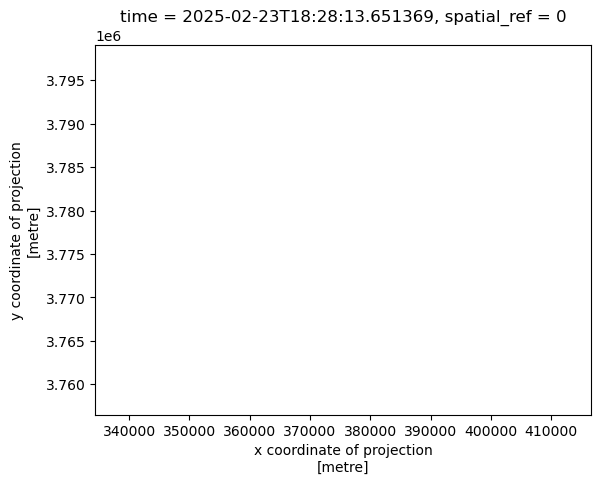

In [12]:
landsat[['red','green','blue']].to_array().plot.imshow()

The true color image looks blank due to the RGB values of the clouds. Their values are outliers that are causing the other RGB values to be squished when plotting. To fix this, adjust the `robust` paramater of the `imshow()` method.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


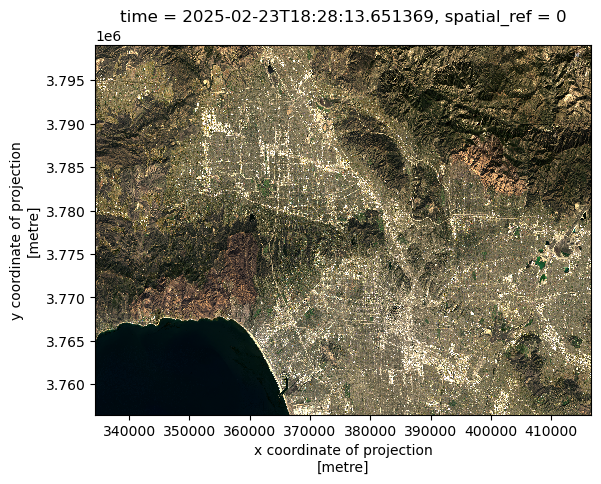

In [13]:
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

To resolve the `RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)` warning, identify the bands with `nan` values, which `.plot.imshow()` sees as invalid.

In [14]:
# use isnan() and .sum() to find the sum of nans in each band in landsat dataset
nan_mask = np.isnan(landsat[['red','green','blue']].to_array()).sum(dim=['y','x'])

In [15]:
# Print the results by band
for band, count in zip(nan_mask['variable'].values, nan_mask.values):
    print(f'{band} band has {count} nans')

red band has 0 nans
green band has 1 nans
blue band has 109 nans


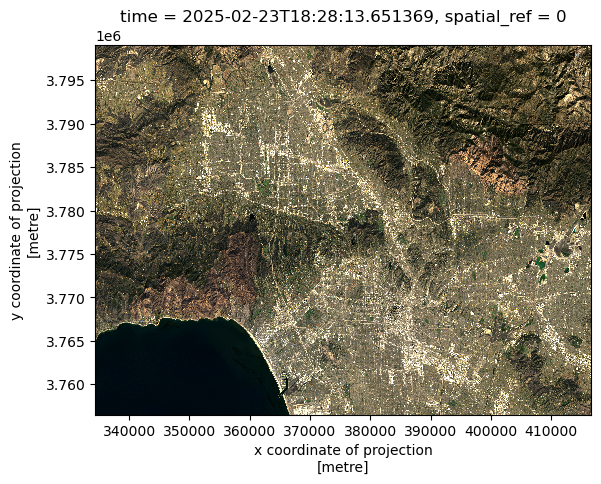

In [16]:
landsat[['red','green','blue']].fillna(value=0).to_array().plot.imshow(robust=True)

## Comparison of part a and e

## False Color Image

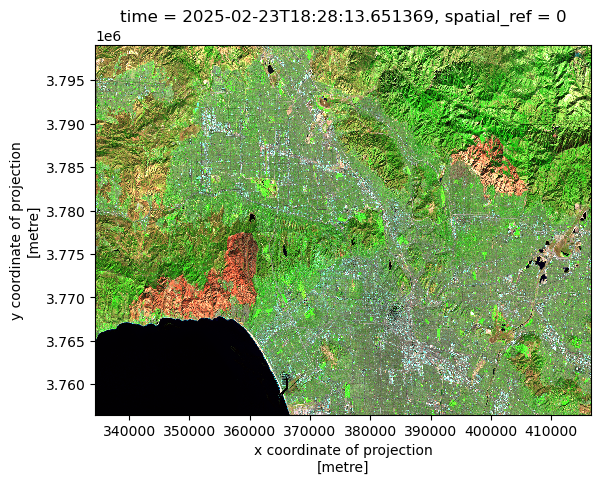

In [17]:
# Plot a false color image using landsat data variables 'swir22','nir08', and 'red' (short-wave infrared, near-infrared, and red band)
landsat[['swir22','nir08','red']].fillna(value=0).to_array().plot.imshow(robust=True)

## Map True Color Image and Fire Perimeters

In [31]:
# Update Eaton and Palisades crs to landsat dataset's crs before plotting 
eaton = eaton.to_crs(landsat.rio.crs)

palisades = palisades.to_crs(eaton.crs)

# Assert that datasets are now on same crs
assert(eaton.crs == palisades.crs == landsat.rio.crs)

Text(340000, 3773000, 'Palisades')

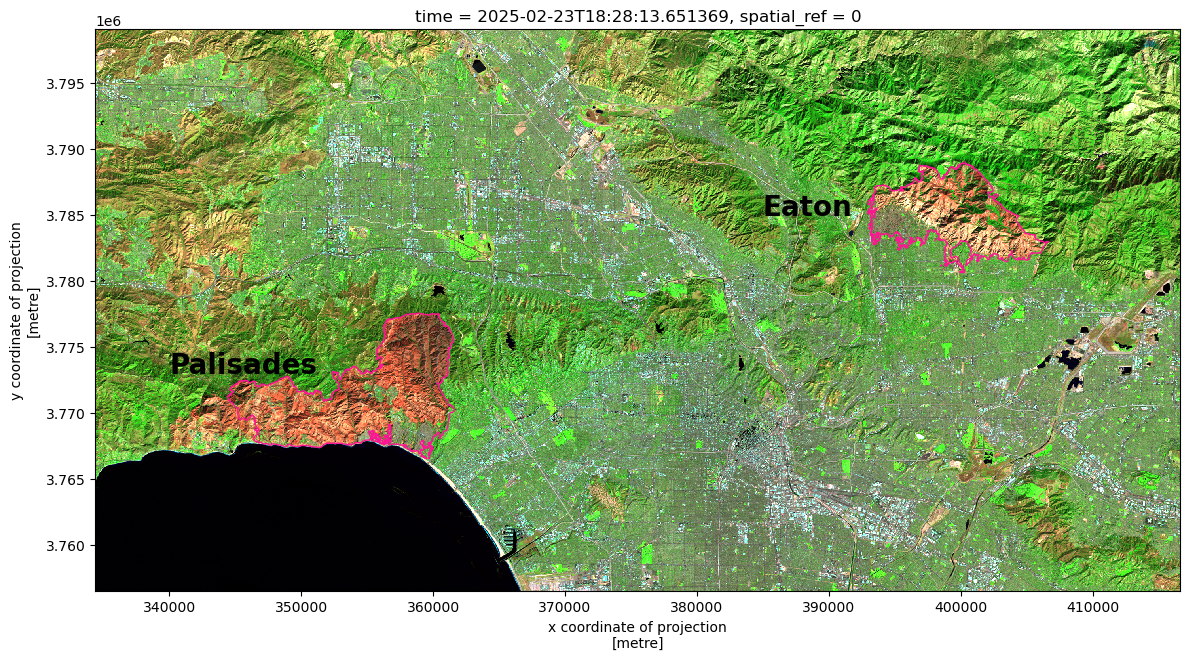

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

landsat[['swir22','nir08','red']].fillna(value=0).to_array().plot.imshow(robust=True,
                                                                        ax=ax)
eaton.plot(ax=ax,
          color = 'none',
          edgecolor = 'deeppink')

palisades.plot(ax=ax,
              color = 'none',
              edgecolor = 'deeppink')


ax.text(x=385000, y=3785000, s="Eaton", fontsize=20, color='black', weight='bold')
ax.text(x=340000, y=3773000, s="Palisades", fontsize=20, color='black', weight='bold')
